In [ ]:
!nvidia-smi

In [2]:
# 如果出现OOM的情况，请根据gpu的显存相应减小 train_bs_ 和 valid_bs_ 的值，我使用的是google的colab提供的V100, 16g显存。

In [3]:
ENV = "colab"

if ENV == "mypc": 
    mydir = 'D:/kaggle/input/cassava-leaf-disease-classification/'
    datadir = 'D:/kaggle/input/cassava-leaf-disease-classification/'
    extradatadir = 'D:/kaggle/input/cassava-leaf-disease-classification/'
    libdir = 'D:/kaggle/input/cassava-leaf-disease-classification/'
    ouputdir = 'D:/kaggle/input/cassava-leaf-disease-classification/'
    train_bs_ = 8
    valid_bs_ = 16
    num_workers_ = 0
elif ENV == "colab": 
    from google.colab import drive
    drive.mount('/content/drive')

    !unzip -nq "/content/drive/Shareddrives/xm/cassava/kaggle_cassava_dataset.zip" -d "/content/"
    !unzip -nq "/content/drive/Shareddrives/xm/cassava/somelibs.zip" -d "/content/"

    !pip install -q pydicom
    !pip install --upgrade -q albumentations
    !pip install --upgrade -q catalyst

    datadir = '/content/'
    extradatadir = '/content/drive/Shareddrives/xm/cassava/archive/'
    libdir = '/content/'
    ouputdir = '/content/drive/Shareddrives/xm/cassava/'
    train_bs_ = 16 
    valid_bs_ = 32
    num_workers_ = 2
elif ENV == "kaggle": 
    datadir = '/kaggle/input/cassava-leaf-disease-classification/'
    extradatadir = '../input/extradata/'
    libdir = '../input/'
    ouputdir = './'
    train_bs_ = 16
    valid_bs_ = 32
    num_workers_ = 4
    package_paths = ['../input/pytorch-image-models/pytorch-image-models-master',
                    '../input/image-fmix/FMix-master']

Mounted at /content/drive
     |████████████████████████████████| 1.9MB 15.7MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 952kB 26.0MB/s 
     |████████████████████████████████| 37.6MB 75kB/s 
     |████████████████████████████████| 491kB 20.8MB/s 
     |████████████████████████████████| 317kB 54.3MB/s 


In [4]:
if ENV != "kaggle":
    package_paths = [f'{libdir}pytorch-image-models-master', f'{libdir}FMix-master',]

if ENV != "mypc":
    !pip install -q pytorch_ranger
    !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    !pip install -q adamp

import sys; 
for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import pydicom
from scipy.ndimage.interpolation import zoom
from pytorch_ranger import Ranger
from warmup_scheduler import GradualWarmupScheduler
from adamp import AdamP

In [5]:
CFG = {
    'normalize_mean':[0.42984136, 0.49624753, 0.3129598],
    'normalize_std':[0.21417203, 0.21910103, 0.19542212],
    'fold_num': 5,
    'seed': 42,
    'train_bs': train_bs_,
    'valid_bs': valid_bs_,
    'num_workers': num_workers_,
    'accum_iter': 2,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tqdm': True,
    'sampler': None, # BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    'do_fmix': False,
    'fmix_p': 0.8,
    'fmix_alpha': 1,
    'fmix_decay_power': 3,
    'fmix_max_soft': True,
    'do_cutmix': True,
    'cutmix_p': 0.5,
    'cutmix_alpha': 1,
    "out_dim": 5,

    # optimizer
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'ranger_eps': 1e-8, 
    # scheduler
    'min_lr': 1e-6,
    "GWS_LR_RAMPUP_EPOCHS": 1,

    'suffix':"0219", 
    'fold_list': [0,1,2,3,4], 
    'model_arch': 'tf_efficientnet_b4_ns', # ["tf_efficientnet_b4_ns", "vit_large_patch16_384", "deit_base_patch16_384", 'resnext50_32x4d', 'vit_base_patch16_384']
    'img_size': 512,   
    'epochs': 15, 
    "n_early_stopping": 5, ####
    
    'schd_batch_update': False,
    'is_freeze': False,  
    'optimizer': "AdamP", # [Adam, AdamW, AdamP, Ranger] AdamP doesn't work on TPUs
    'scheduler': "CosineAnnealingWarmRestarts", # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'GradualWarmupSchedulerV2']
    'loss_fn': "TaylorCrossEntropyLoss", # [TaylorCrossEntropyLoss]
    'use2019': False,
    'use_extraandtest2019': False,  
    'del_rate': 1, 
    "del_confident": True, 
    "del_percent": 0.5,
    
    'n_frozen_epochs': 5,  
    'n_frozen_layers': 3,  
    'only_bn': False, 
    'frozen_close_scheduler': False, 
    
    # loss
    "BiTempered_t1": 0.8, 
    "BiTempered_t2": 1.2, 
    "smoothing": 0.01,
    
} 


DEBUG = False ####

# helper

In [6]:
train_2020 = pd.read_csv(f'{datadir}train.csv')
train_2020_len = len(train_2020)
submission = pd.read_csv(f'{datadir}sample_submission.csv')

if CFG["del_confident"]:
    soft_targets_2020 = pd.read_csv(f'{extradatadir}soft_targets_2020.csv')
    soft_argmax_df_2020 = pd.Series(np.argmax(soft_targets_2020[["p0","p1","p2","p3","p4"]].values,axis=1))
    soft_max_df_2020 = pd.Series(np.max(soft_targets_2020[["p0","p1","p2","p3","p4"]].values,axis=1))
    soft_train_df_2020 = pd.concat([train_2020, soft_argmax_df_2020, soft_max_df_2020],axis=1)
    soft_train_df_2020.columns = ["image_id", "label", "soft_argmax_label", "soft_max"]
    train_2020 = soft_train_df_2020.query(f"label == soft_argmax_label or soft_max <= {CFG['del_percent']}")[["image_id","label"]].reset_index(drop=True)
    print(f"Keep {len(train_2020)/train_2020_len} of the 2020_data")
    train_df = train_2020
    
skf = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed'])
folds = [(idxT,idxV) for (idxT,idxV) in skf.split(np.arange(train_2020.shape[0]), train_2020['label'])]
DATA_FOLD = f'{datadir}train_images/'

Keep 0.9548067486096181 of the 2020_data


In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed_all(seed)
    
def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  

def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

                
def freeze_layer(model, cur_epoch, n_frozen_epochs, n_frozen_layers, only_bn): 
    mcnt1 = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            mcnt1 += 1
    ##        
    layer_cnt = 0
    if cur_epoch < n_frozen_epochs:
        sub_model = next(model.children())
        for layer in sub_model.children():
            if only_bn:
                if isinstance(layer, nn.BatchNorm2d):
                    if layer_cnt < n_frozen_layers:
                        layer_cnt += 1
                        for param in layer.parameters():
                            param.requires_grad = False

            else:
                if layer_cnt < n_frozen_layers:
                    layer_cnt += 1
                    for param in layer.parameters():
                        param.requires_grad = False
        if 'efficientnet' in CFG["model_arch"]:
            classifier_layer = sub_model.classifier.parameters()
        elif 'vit' in CFG["model_arch"] or 'deit' in CFG["model_arch"]:
            classifier_layer = sub_model.head.parameters()
        elif 'resnext' in CFG["model_arch"]:
            classifier_layer = sub_model.fc.parameters()

        for param in classifier_layer:
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True
    
    ##
    mcnt2 = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            mcnt2 += 1
    print(mcnt1,mcnt2)

# Dataset

In [8]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                        'alpha': CFG["fmix_alpha"], 
                        'decay_power': CFG["fmix_decay_power"], 
                        'shape': (CFG['img_size'], CFG['img_size']),
                        'max_soft': CFG["fmix_max_soft"], 
                        'reformulate': False
                        },
                 do_cutmix=False,
                 cutmix_params={'alpha': CFG["cutmix_alpha"],},
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))
        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > CFG["fmix_p"]:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > CFG["cutmix_p"]:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4) 
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
        if self.output_label == True:
            return img, target 
        else:
            return img

In [9]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():  
    return Compose([
        RandomResizedCrop(CFG['img_size'], CFG['img_size']),
        Transpose(p=0.5),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(p=0.5),
        HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=30, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.3,0.3), contrast_limit=(-0.3, 0.3), p=0.5),
        Normalize(mean=CFG["normalize_mean"], std=CFG["normalize_std"], max_pixel_value=255.0, p=1.0), 
        CoarseDropout(p=0.5),
        Cutout(p=0.5),
        ToTensorV2(p=1.0),
    ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
        RandomCrop(CFG['img_size'], CFG['img_size']),
        Transpose(p=0.5),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=CFG["normalize_mean"], std=CFG["normalize_std"], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
        ], p=1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

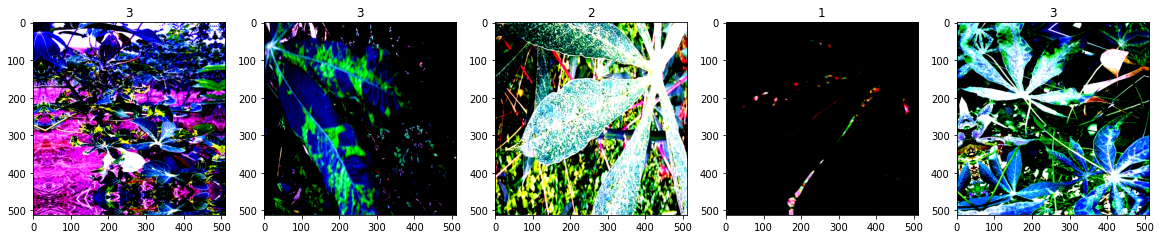

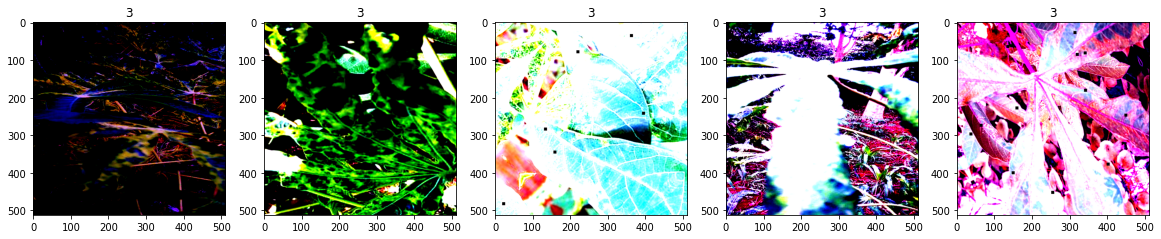

In [10]:
from pylab import rcParams
dataset_show = CassavaDataset(train_2020, data_root=f'{datadir}train_images/', transforms=get_train_transforms())
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Loss

In [11]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer = None, multiplier = 7, total_epoch = CFG["GWS_LR_RAMPUP_EPOCHS"], after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
        self.after_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CFG["epochs"] - CFG["GWS_LR_RAMPUP_EPOCHS"],
                                            T_mult=1, eta_min=CFG["min_lr"], last_epoch=-1)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [12]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out

class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    

class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.2):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG["out_dim"], smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

# Model

In [13]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        if 'deit' in model_arch:
            self.model = torch.hub.load('facebookresearch/deit:main', model_arch, pretrained=pretrained)
        else:
            self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
        elif 'vit' in model_arch or 'deit' in model_arch:
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, n_class)
        elif 'resnext' in model_arch:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, n_class)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=f'{datadir}train_images/'):
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, do_cutmix=CFG["do_cutmix"], do_fmix=CFG["do_fmix"],)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True if CFG["sampler"] is None else False,     
        num_workers=CFG['num_workers'],
        sampler=CFG["sampler"]
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        pin_memory=True, 
        shuffle=False,
        num_workers=CFG['num_workers'],
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()
    
    time1 = time.time()
    running_loss = None
    trn_epoch_result = dict()
    progress = tqdm(enumerate(train_loader), total=len(train_loader)) if CFG["tqdm"] else enumerate(train_loader)

    for step, (imgs, image_labels) in progress:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        with autocast(): # 自动混合精度
            image_preds = model(imgs)   #output = model(input)
            loss = loss_fn(image_preds, image_labels) # loss
            scaler.scale(loss).backward() # backward
            
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    if not CFG['is_freeze'] or CFG['frozen_close_scheduler'] == False or epoch+1 >= CFG['n_frozen_epochs']:
                        scheduler.step()
            if CFG["tqdm"]:
                trn_epoch_result['Epoch'] = epoch
                trn_epoch_result['train_loss'] = round(running_loss, 4)
                trn_epoch_result['LR'] = round(optimizer.param_groups[0]["lr"],7)
                progress.set_description(str(trn_epoch_result))
    time2 = time.time()
    time_diff = get_timediff(time1,time2)
    
    if not CFG["tqdm"]:       
        print(f'epoch_{epoch}, {time_diff}, loss:{running_loss:.4f}, curtime: {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}')
            
    if scheduler is not None and not schd_batch_update:
        if not CFG['is_freeze'] or CFG['frozen_close_scheduler'] == False or epoch+1 >= CFG['n_frozen_epochs']:
            scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    time1 = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    for step, (imgs, image_labels) in enumerate(val_loader):
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)

        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    time2 = time.time()
    time_diff = get_timediff(time1,time2)
    v_acc = (image_preds_all==image_targets_all).mean()
    v_loss = loss_sum/sample_num
    

    print(f'epoch_{epoch}, {time_diff}, loss:{v_loss:.4f}, valid acc:{v_acc:.4f}\n')

    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(v_loss)
        else:
            scheduler.step()

    return v_acc, v_loss

# Training

In [ ]:
seed_everything(CFG['seed'])

print(CFG["suffix"])
for fold, (trn_idx, val_idx) in enumerate(folds):
    valid_acc_log = []; valid_loss_log = []
    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    
    if fold in CFG["fold_list"]: 
        print('Training fold {} started'.format(fold))
        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train_df, trn_idx, val_idx, data_root=DATA_FOLD)
        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train_2020.label.nunique(), pretrained=True).to(device)
        
        scaler = GradScaler()  

        # optimizer
        if CFG["optimizer"] == "Adam": 
            if CFG["scheduler"] == "GradualWarmupSchedulerV2": 
                optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"]/7, weight_decay=CFG['weight_decay'])
            else:
                optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        
        elif CFG["optimizer"] == 'Ranger':
            optimizer = Ranger(model.parameters(), lr=CFG["lr"], alpha=0.5, k=6, N_sma_threshhold=5, betas=(0.95,0.999),
                                eps=CFG["ranger_eps"], weight_decay=CFG["weight_decay"])

        elif CFG["optimizer"] == 'AdamW':
            if CFG["scheduler"] == "GradualWarmupSchedulerV2":
                optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"]/7, weight_decay=CFG["weight_decay"])
            else:
                optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
                
        elif CFG["optimizer"] == 'AdamP':
            if CFG["scheduler"] == "GradualWarmupSchedulerV2":
                optimizer = AdamP(model.parameters(), lr=CFG["lr"]/7, weight_decay=CFG["weight_decay"])
            else:
                optimizer = AdamP(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
        
        # scheduler
        if CFG["scheduler"] == "CosineAnnealingWarmRestarts":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['epochs'], T_mult=1,
                                            eta_min=CFG['min_lr'], last_epoch=-1) 
        elif CFG["scheduler"] == "GradualWarmupSchedulerV2":
            scheduler = GradualWarmupSchedulerV2(optimizer)
        
        # loss    
        if CFG["loss_fn"] == "TaylorCrossEntropyLoss":
            loss_fn = TaylorCrossEntropyLoss(n=2, smoothing = CFG["smoothing"])

        for epoch in range(CFG['epochs']):
            if CFG["is_freeze"]:
                freeze_layer(model, epoch, CFG["n_frozen_epochs"], CFG["n_frozen_layers"], CFG["only_bn"]) 
            train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=CFG['schd_batch_update'])
            with torch.no_grad():
                valid_acc, valid_loss  = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)
                valid_acc_log.append(valid_acc)
                valid_loss_log.append(valid_loss)

            torch.save(model.state_dict(), f'{ouputdir}{CFG["model_arch"]}_{CFG["suffix"]}_fold_{fold}_{epoch}')
            # early stopping
            if valid_acc > valid_acc_max:
                valid_acc_max = valid_acc
                valid_acc_max_cnt=0
            else:
                valid_acc_max_cnt+=1

            if valid_loss < valid_loss_min:
                valid_loss_min = valid_loss
                valid_loss_min_cnt=0
            else:
                valid_loss_min_cnt+=1

            if valid_acc_max_cnt >= CFG["n_early_stopping"] and valid_loss_min_cnt >= CFG["n_early_stopping"]:
                print("early_stopping")
                break
        
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()